# Preparing Data 4 the AE

### Import and function definition

In [49]:
import pandas as pd
import numpy as np
import timeit, math, os, copy, yaml, ast
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
#%load_ext memory_profiler

In [50]:
def Make_img(histo, Xbins, Xmin, Xmax, Ybins, Ymin, Ymax):
    img = np.zeros((100, 100), dtype=np.float32)
    
    for i in range(int(Ybins)):
        for j in range(int(Xbins)):
            img[i, j] = histo[i][j]#histo[i*(int(Xbins)+2)+j]
    #img = img[1:-1, 1:-1]
    return img
    
def Show2Dimg(img, title='CSC occupancy'):
    fig = plt.figure(figsize =(8, 8))
    img_temp = copy.deepcopy(img)
    cmap = plt.cm.jet
    cmap.set_under(color='white')
    max_=np.max(img_temp)
    img_temp[img_temp==0] = np.nan
    plt.imshow(img_temp, cmap=cmap, vmin=0.0000000001, vmax=max_)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.show()
    del img_temp
    #plt.savefig('CSC_occupancy.png')

In [51]:
def Show1Dimg(vx, vy, xfit=None, yfit=None, x=r"Lumi [10$^{33}$ cm$^{-2}$ s$^{-1}$]", y="Occupancy (Hits/LS)", eymin=4, eymax=4, marker='.', line=False):
    plt.figure(figsize=(7, 4))
    if line==True:
        plt.axvline(x=9, color='red', linestyle='--')
    plt.plot(vx, vy, marker=marker, linestyle='', markersize=5, label='Data')
    if yfit is not None:
        plt.plot(xfit, yfit, color='red', label='Fit')
        plt.legend()
    plt.xlabel(x, size='14')
    plt.ylabel(y, size='14')
    #plt.ylim(0, 2000000)
    plt.grid(True)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(eymin,eymax))
    plt.rc('xtick', labelsize='12')
    plt.rc('ytick', labelsize='12')
    plt.title(r'$\mathbf{CMS}\ \mathit{Private\ work}$', x=0.24, y=1.0, size=14)
    #plt.title('CMS', fontweight='bold',x=0.12, y=1.0, size=14)
    plt.title('2023 (13.6 TeV)',loc='right', size=14)
    plt.legend()
    plt.show()

In [52]:
me = "hRHGlobalm3"
path = "/eos/cms/store/group/ml/AD4MVDHackathon/Anomaly_detection_Data/MEs/"
monitoring_elements = pd.read_parquet(path + me + '_files_p1.parquet')

In [53]:
#removing from dataset instances corresponding to zero inst luminosity
monitoring_elements = monitoring_elements[monitoring_elements["mean_lumi"] > 2]

In [54]:
#normalising to lumi/1000 to get entries * pb-1s-1 as unit
monitoring_elements["data_norm"] = monitoring_elements["data"]/(0.001*monitoring_elements["mean_lumi"])
monitoring_elements["entries_norm"] = monitoring_elements["entries"]/(0.001*monitoring_elements["mean_lumi"])

### Occupancy Plots

#### Occupancy vs Lumi

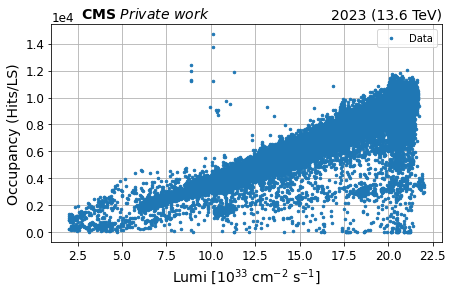

In [55]:
Show1Dimg(monitoring_elements['mean_lumi'], monitoring_elements['entries'])

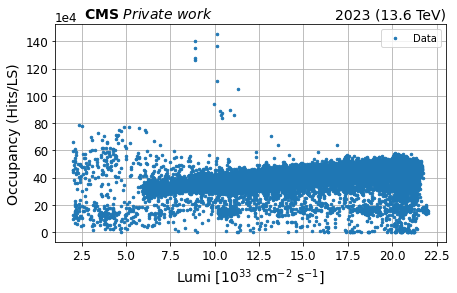

In [56]:
Show1Dimg(monitoring_elements['mean_lumi'], monitoring_elements['entries_norm'])

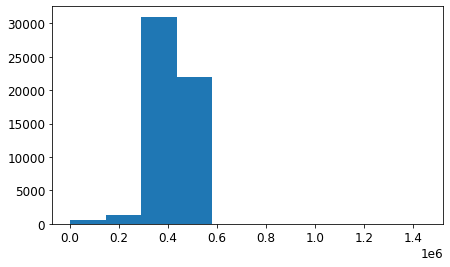

In [57]:
plt.figure(figsize=(7, 4))
plt.hist(monitoring_elements['entries_norm'] )
plt.show()

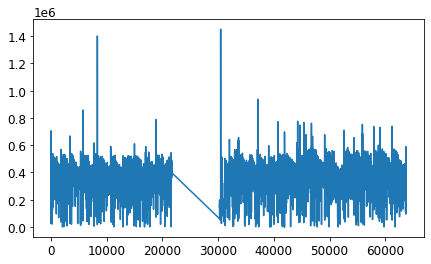

In [58]:
plt.figure(figsize=(7, 4))
plt.plot(monitoring_elements['entries_norm'])
plt.show()

In [59]:
mean_entries_norm = np.mean(monitoring_elements['entries_norm'])
std_entries_norm = np.std(monitoring_elements['entries_norm'])
up = mean_entries_norm+1*std_entries_norm
down = mean_entries_norm-1*std_entries_norm

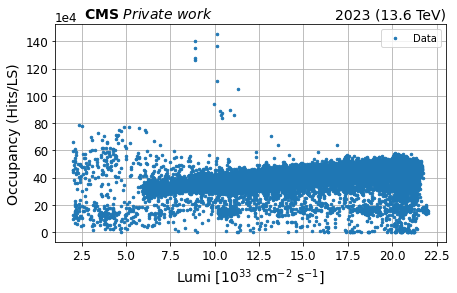

In [60]:
#remove outliers
monitoring_elements = monitoring_elements[((monitoring_elements["entries_norm"] > down) | (monitoring_elements["entries_norm"] < up) )]
Show1Dimg(monitoring_elements['mean_lumi'], monitoring_elements['entries_norm'])

In [61]:
monitoring_elements = monitoring_elements.reset_index()

### Sum over LS

Mean lumi: 2.181817071533


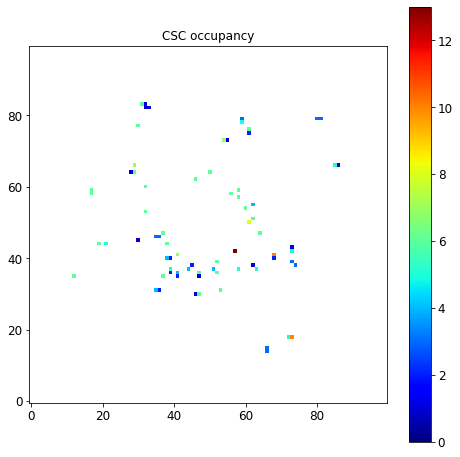

Mean lumi: 20.068316992187498


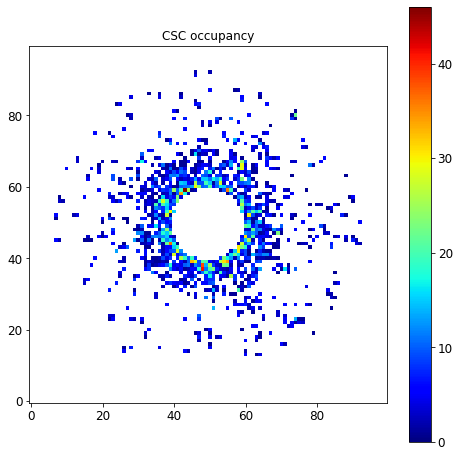

In [62]:
print("Mean lumi:", monitoring_elements["mean_lumi"][0])
img = Make_img(monitoring_elements['data'][0], monitoring_elements['x_bin'][0], monitoring_elements['x_min'][0], monitoring_elements['x_max'][0], monitoring_elements['y_bin'][0], monitoring_elements['y_min'][0], monitoring_elements['y_max'][0])
Show2Dimg(img)
print("Mean lumi:", monitoring_elements["mean_lumi"][2000])
img = Make_img(monitoring_elements['data'][2000], monitoring_elements['x_bin'][0], monitoring_elements['x_min'][0], monitoring_elements['x_max'][0], monitoring_elements['y_bin'][0], monitoring_elements['y_min'][0], monitoring_elements['y_max'][0])
Show2Dimg(img)

In [158]:
def XY_to_Polar(img):
    imgpolar = np.zeros((34, round(8*(2*math.pi))), dtype=np.float32)
    center = (49.5, 49.5)
    for i in range(100):
        for j in range(100):
            if(img[i,j]!=0):
                dist = np.sqrt((i-center[0])**2+(j-center[1])**2) -11
                theta = np.arctan2((j-center[1]), (i-center[0]))
                theta = theta + math.pi
                try:
                    if int(theta*8) == int(8*(2*math.pi)):
                        imgpolar[int(dist), 0] += img[i,j]
                    else:
                        imgpolar[int(dist), int(theta*8)] += img[i,j]
                except:
                    pass
    imgpolar[33,:]=0
    return imgpolar

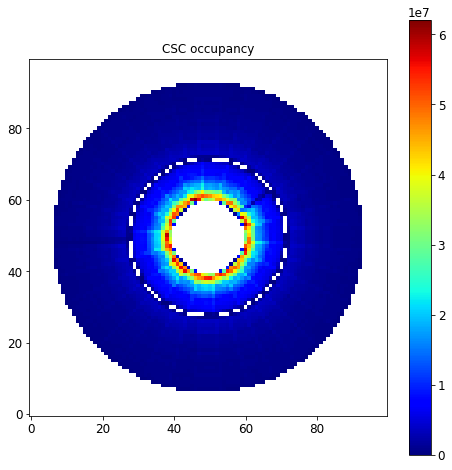

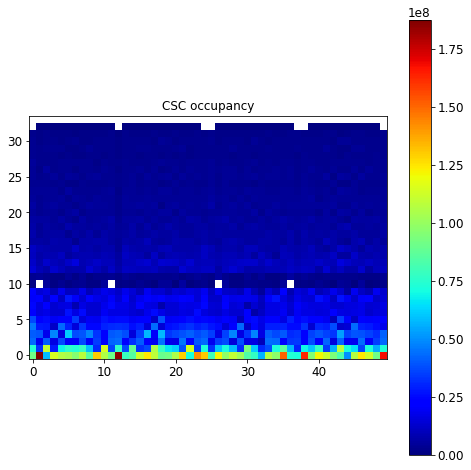

In [159]:
Show2Dimg(sum_img)
Show2Dimg(XY_to_Polar(sum_img))


In [148]:
def simulate_bad(good_imgs):
    center = (49.5, 49.5)  # Center coordinates
    # random cut for angle and radius
    rand_down_angle = np.random.randint(0,340)
    rand_angle = np.random.randint(10,20)
    rand_up_angle = rand_down_angle + rand_angle
    angle_range = (rand_down_angle, rand_up_angle)  # min 10 degrees, max 20 degrees
    rand_down_radius = np.random.rand()
    rand_radius = float(np.random.randint(50,100) / 500) # min 10% max 50% of the white space
    rand_up_radius = rand_down_radius + rand_radius
    radius_range = (rand_down_radius, rand_up_radius)  

    modified_matrix = set_zero_in_angle_and_radius_range(good_imgs, center, angle_range, radius_range)

    return modified_matrix

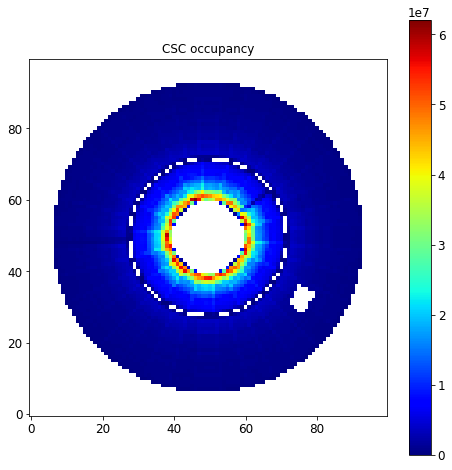

In [152]:
sum_img = Make_img(sum(monitoring_elements['data_norm']), monitoring_elements['x_bin'][0], monitoring_elements['x_min'][0], monitoring_elements['x_max'][0], monitoring_elements['y_bin'][0], monitoring_elements['y_min'][0], monitoring_elements['y_max'][0])
sum_img_test = np.copy(sum_img)
Show2Dimg(simulate_bad(sum_img_test))

In [151]:
def hadd_img(df, lumi_threshold):
    count = 0
    summed_img = []
    summed_lumi = []
    summed_entries = []
    summed_number = []
    dfs = []
    count = 0
    for it in range(len(df)):
        new_row = {'data_norm': df['data_norm'][it], 'lumi': df['mean_lumi'][it], 'entries_norm': df['entries_norm'][it]}
        dfs.append(new_row)
        count +=1
        df_temp = pd.DataFrame(dfs)
        sumlumi = sum(df_temp['lumi'])
        if sumlumi >lumi_threshold: #to be divided by 1000 to get pb-1/s
            sumdata = sum(df_temp['data_norm'])
            summed_img.append(XY_to_Polar(Make_img(sumdata, df['x_bin'][0], df['x_min'][0], df['x_max'][0], df['y_bin'][0], df['y_min'][0], df['y_max'][0])))
            summed_lumi.append(sumlumi)
            summed_entries.append(sum(df_temp['entries_norm']))
            summed_number.append(count)
            count = 0
            dfs = []
            del sumdata
        del df_temp
        del sumlumi
        del new_row
    print("Total imgs: ",len(summed_img))
    return summed_img, summed_lumi, summed_entries, summed_number


import numpy as np

def set_zero_in_angle_and_radius_range(matrix, center, angle_range, radius_range):
    """
    Set the values within the specified angle and radius range in the matrix to 0.
    
    Parameters:
    - matrix: Input 100x100 matrix.
    - center: Center coordinates (x, y).
    - angle_range: Angle range (start_angle, end_angle) in degrees.
    - radius_range: Radius range (start_radius, end_radius) as a percentage of the maximum radius.
    
    Returns:
    - Modified matrix.
    """
    rows, cols = matrix.shape
    max_radius = matrix.shape[0] // 2
    start_radius, end_radius = radius_range[0] * max_radius, radius_range[1] * max_radius
    start_angle, end_angle = np.deg2rad(angle_range)  # Convert angle to radians
    
    for i in range(rows):
        for j in range(cols):
            # Calculate the angle and distance of the current point relative to the center
            dy = j - center[1]
            dx = i - center[0]
            dist = np.sqrt(dx**2 + dy**2)
            theta = np.arctan2(dy, dx)
            if theta < 0:
                theta += 2 * np.pi  # Adjust the angle range to [0, 2π]
#             print('dist', dist)
            # Check if the angle and distance are within the specified range
            if (dist > start_radius) & (dist < end_radius) & (start_angle <= theta <= end_angle):
                matrix[i, j] = 0
    
    return matrix


def simulate_bad(good_imgs):
    center = (49.5, 49.5)  # Center coordinates
    # random cut for angle and radius
    rand_down_angle = np.random.randint(0,340)
    rand_angle = np.random.randint(10,20)
    rand_up_angle = rand_down_angle + rand_angle
    angle_range = (rand_down_angle, rand_up_angle)  # min 10 degrees, max 20 degrees
    rand_down_radius = np.random.rand()
    rand_radius = float(np.random.randint(50,100) / 500) # min 10% max 50% of the white space
    rand_up_radius = rand_down_radius + rand_radius
    radius_range = (rand_down_radius, rand_up_radius)  

    modified_matrix = set_zero_in_angle_and_radius_range(good_imgs, center, angle_range, radius_range)

    return modified_matrix

def hadd_img_simulated_bad(df, lumi_threshold):
    count = 0
    summed_img = []
    summed_lumi = []
    summed_entries = []
    summed_number = []
    dfs = []
    count = 0
    for it in range(len(df)):
        new_row = {'data_norm': df['data_norm'][it], 'lumi': df['mean_lumi'][it], 'entries_norm': df['entries_norm'][it]}
        dfs.append(new_row)
        count +=1
        df_temp = pd.DataFrame(dfs)
        sumlumi = sum(df_temp['lumi'])
        if sumlumi >lumi_threshold: #to be divided by 1000 to get pb-1/s
            sumdata = sum(df_temp['data_norm'])
            img = Make_img(sumdata, df['x_bin'][0], df['x_min'][0], df['x_max'][0], df['y_bin'][0], df['y_min'][0], df['y_max'][0])
            summed_img.append(XY_to_Polar(simulate_bad(img)))
            summed_lumi.append(sumlumi)
            summed_entries.append(sum(df_temp['entries_norm']))
            summed_number.append(count)
            count = 0
            dfs = []
            del sumdata
        del df_temp
        del sumlumi
        del new_row
    print("Total imgs: ",len(summed_img))
    return summed_img, summed_lumi, summed_entries, summed_number

XY origin plot


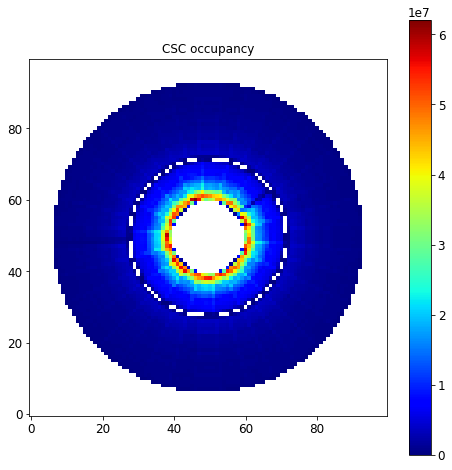

XY bad plot


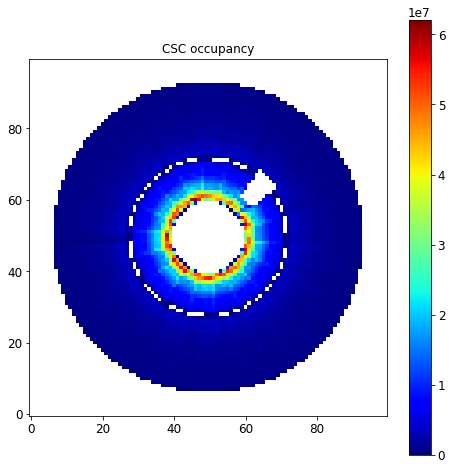

polar origin plot


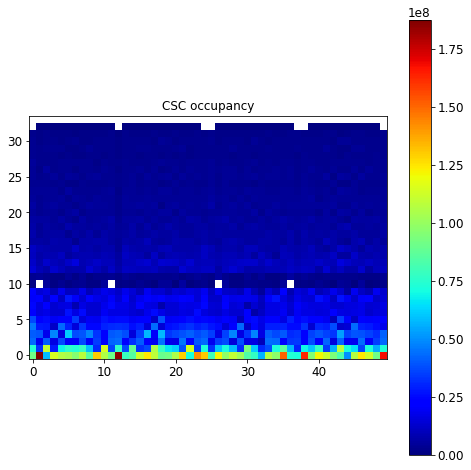

polar bad plot


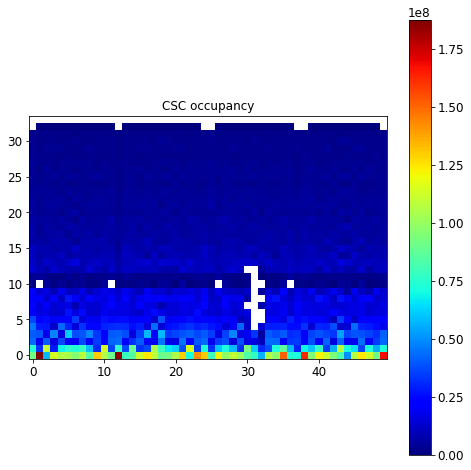

In [165]:
# have a look on good and bad plot
sum_img = Make_img(sum(monitoring_elements['data_norm']), monitoring_elements['x_bin'][0], monitoring_elements['x_min'][0], monitoring_elements['x_max'][0], monitoring_elements['y_bin'][0], monitoring_elements['y_min'][0], monitoring_elements['y_max'][0])
sum_img_copy = np.copy(sum_img)
modified_matrix = simulate_bad(sum_img_copy)
print("XY origin plot")
Show2Dimg(sum_img)
print("XY bad plot")
Show2Dimg(modified_matrix)
print("polar origin plot")
Show2Dimg(XY_to_Polar(sum_img))
print("polar bad plot")
Show2Dimg(XY_to_Polar(modified_matrix))


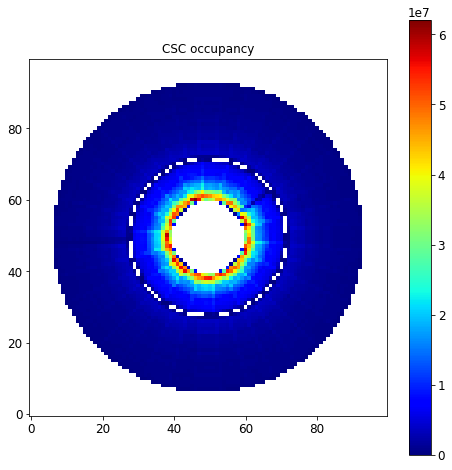

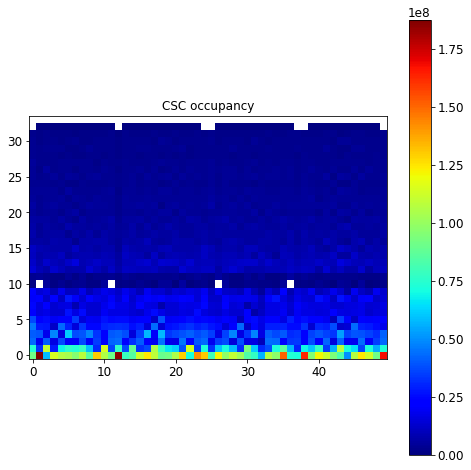

In [160]:
#have a look to the total (summed) distribution
sum_img = Make_img(sum(monitoring_elements['data_norm']), monitoring_elements['x_bin'][0], monitoring_elements['x_min'][0], monitoring_elements['x_max'][0], monitoring_elements['y_bin'][0], monitoring_elements['y_min'][0], monitoring_elements['y_max'][0])
Show2Dimg(sum_img)
Show2Dimg(XY_to_Polar(sum_img))

In [161]:
len(monitoring_elements)

54868

In [ ]:
#hadding consecutive ls to get a given total lumi
# imgs, lumis, entry, num = hadd_img(monitoring_elements, 300) #corresponds to 0.3 pb-1/s
imgs_bad_simulated, lumis_bad_simulated, entry_bad_simulated, num_bad_simulated = hadd_img_simulated_bad(monitoring_elements, 300) #corresponds to 0.3 pb-1/s

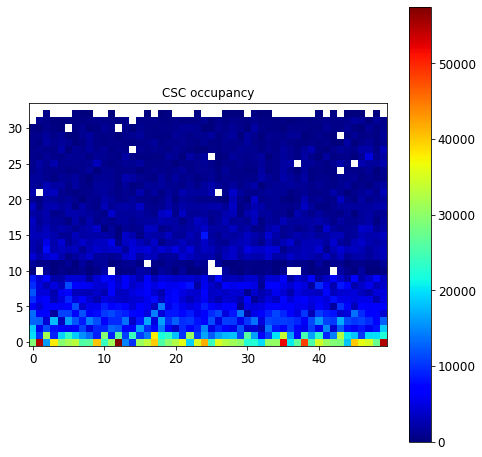

In [163]:
Show2Dimg(imgs_bad_simulated[2])

In [ ]:
#this plot tells you how many consequent ls were summed up
plt.hist(num, bins=50, range=(10, 30), edgecolor='black')
plt.xlabel('# of summed LSs')
plt.ylabel('Entries')
plt.show()

In [ ]:
Show1Dimg(lumis, entry)

In [22]:
np.savez(me+'_files.npz', imgs=imgs, lumis=lumis, entry=entry, num=num)